# Identify fraud from Enron data set
### by Shiu-Tang Li

## 1. Introduction

In 2000, Enron was one of the largest companies in the US, but soon it went bankruptcy due to corporate fraud. The goal of this project is use machine learning knowledge to build identifiers to predict who is a POI (person of interest) based on the Enron data set. POI means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity. 

### 1.1 Data set quick overview 

The Enron data set used to build the machine learning prediction model in this report contains 146 personal data, with 21 features. These features are:

#### A. POI (Person of interst) label: 

'poi': '1' means this person is POI. '0' means this person is NOT a POI. In this training data set there're 18 POIs.

#### B. Financial features (all units are in US dollars): 
##### B.1 Payments 
Features include: 'salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments', 'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments'.
##### B.2 Stock Value 
Features include: 'exercised_stock_options',  'restricted_stock', 'restricted_stock_deferred', 'total_stock_value'. 

#### C. Email features: 
Features include: 'email_address', 'to_messages', 'from_messages', 'from_poi_to_this_person',   'from_this_person_to_poi', 'shared_receipt_with_poi'. 

'email_address' is a text string; units other than 'email_address' are number of emails messages. 


### 1.2 table of contents

**2 Data cleaning **

2.1 Missing values removal / interpretation <br />
2.2 Removing other outliers

**3 Tranformation of data set **

3.1 New features<br />
3.2 Logarithmic transformation of financial features <br />
3.3 Feature scaling (substract by mean and then divide by standard dev)  

** 4 Feature selection **

** 5 Applying machine learning algorithms **

5.1 Comparison of different algorithms <br />
5.2 Adjusting number of features used

** 6 Data leakage filters **

** 7 Vaildation and evaluation**

7.1 Evaluation metric <br />
7.2 Cross validation methods 

** 8 Reflection **

In [42]:
####  Snippet by Max Masnick       https://www.maxmasnick.com/
####  Used to hide all codes

import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

## 2. Data cleaning

In this section, I would perform analysis to figure out if the missing values are actually zeros, and if not how do I deal with these missing values. Then I'll check through the data set to see if there're any outliers that I better off dicarding them when I build models.

In [2]:
import sys
import pickle
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt

sys.path.append("../tools/")

from tester2 import test_classifier

financial_feature = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 
                     'deferral_payments', 'loan_advances', 'other', 'expenses', 
                     'director_fees', 'total_payments',
                     'exercised_stock_options', 'restricted_stock', 
                     'restricted_stock_deferred', 'total_stock_value']
email_feature = ['to_messages', 'from_messages', 
                 'from_poi_to_this_person', 'from_this_person_to_poi', 
                 'shared_receipt_with_poi']
features_list = ['poi'] +  financial_feature + ['email_address'] + email_feature
features_list_no_email_no_poi = financial_feature + email_feature

with open("final_project_dataset.pkl", "r") as data_file:
    data = pickle.load(data_file)

### 2.1 Missing values removal / interpretation

First, I do a quick analysis to check how many NaN's appear in each feature, and how many POI's appear in NaN group and non-NaN group. It turns out that there're a lot of NaNs.

In [3]:
print("ROP: ratio of number of POIs to number of people in group")
print("")
print(("Feature name").ljust(24) +  ("ROP in NaNs").rjust(9) + "  ROP in non-NaNs")
print("")

for key in features_list:
    ctr1 = 0
    ctr2 = 0
    ctr3 = 0
    for row in data:
        if (data[row][key] == "NaN"):
            ctr1 += 1
        if (data[row][key] == "NaN") and (data[row]['poi'] == True):
            ctr2 += 1
        if (data[row][key] != "NaN") and (data[row]['poi'] == True):
                ctr3 += 1
    print ((key).ljust(26)  + (str(ctr2)+"/"+str(ctr1)).rjust(9) +
                (str(ctr3)+"/"+str(146 - ctr1)).rjust(12))

ROP: ratio of number of POIs to number of people in group

Feature name            ROP in NaNs  ROP in non-NaNs

poi                             0/0      18/146
salary                         1/51       17/95
bonus                          2/64       16/82
long_term_incentive            6/80       12/66
deferred_income                7/97       11/49
deferral_payments            13/107        5/39
loan_advances                17/142         1/4
other                          0/53       18/93
expenses                       0/51       18/95
director_fees                18/129        0/17
total_payments                 0/21      18/125
exercised_stock_options        6/44      12/102
restricted_stock               1/36      17/110
restricted_stock_deferred    18/128        0/18
total_stock_value              0/20      18/126
email_address                  0/35      18/111
to_messages                    4/60       14/86
from_messages                  4/60       14/86
from_poi_to_this_person

Let me check if there're any records which contains all NaNs. And there is one such record.

In [4]:
for row in data:
    NaNctr = 0
    for key in features_list:
        if data[row][key] == 'NaN':
            NaNctr += 1
    if NaNctr >= 20:
        print(row, data[row])

('LOCKHART EUGENE E', {'salary': 'NaN', 'to_messages': 'NaN', 'deferral_payments': 'NaN', 'total_payments': 'NaN', 'exercised_stock_options': 'NaN', 'bonus': 'NaN', 'restricted_stock': 'NaN', 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': 'NaN', 'total_stock_value': 'NaN', 'expenses': 'NaN', 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 'NaN', 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'})


I'm wondering whether these NaNs are actually zeros but are just stored as NaNs. Let me first check if there're any zeros in each feature.

In [5]:
print(("Feature name").ljust(24) +  ("Number of zeros").rjust(9))

for key in features_list:
    ctr = 0
    for row in data:
        if (data[row][key] == 0):
            ctr += 1
    print ((key).ljust(26)  + str(ctr))

Feature name            Number of zeros
poi                       128
salary                    0
bonus                     0
long_term_incentive       0
deferred_income           0
deferral_payments         0
loan_advances             0
other                     0
expenses                  0
director_fees             0
total_payments            0
exercised_stock_options   0
restricted_stock          0
restricted_stock_deferred 0
total_stock_value         0
email_address             0
to_messages               0
from_messages             0
from_poi_to_this_person   12
from_this_person_to_poi   20
shared_receipt_with_poi   0


Now it seems like the NaNs in financial features are zeros, but the NaNs in email features are not (there're both zeros and NaNs in the dataset). So my next step is to replace NaNs in financial features with zeros, and then check for each record if the sum of all payments equals the total payment, and if the sum of all stock values equals total stock value.

In [6]:
# make a deep copy of the original dataset
cleaned_data = deepcopy(data)

# replace NaN with zero
for person in cleaned_data:
    for key in cleaned_data[person]:
        for row in cleaned_data:
            if (cleaned_data[row][key] == "NaN"):
                cleaned_data[row][key] =0
    break

ctr_match = 0
for i, key in enumerate(cleaned_data):
    tot =(cleaned_data[key]['salary'] + 
          cleaned_data[key]['bonus'] +
          cleaned_data[key]['long_term_incentive'] +
          cleaned_data[key]['deferred_income'] +
          cleaned_data[key]['deferral_payments'] +
          cleaned_data[key]['loan_advances'] +
          cleaned_data[key]['other'] +
          cleaned_data[key]['expenses'] +
          cleaned_data[key]['director_fees'])
    if tot ==  cleaned_data[key]['total_payments']:
        ctr_match += 1
    if tot !=  cleaned_data[key]['total_payments']:
        print(key, tot, cleaned_data[key]['total_payments'])

print("The number of matches of 'sum of all payments' and 'total payment': " + str(ctr_match))
print("")

ctr_match = 0
for i, key in enumerate(cleaned_data):
    tot =(cleaned_data[key]['exercised_stock_options'] + 
          cleaned_data[key]['restricted_stock'] +
          cleaned_data[key]['restricted_stock_deferred'])
    if tot ==  cleaned_data[key]['total_stock_value']:
        ctr_match += 1
    if tot !=  cleaned_data[key]['total_stock_value']:
        print(key, tot, cleaned_data[key]['total_stock_value'])

print("The number of matches of 'sum of all stock values' and 'total stock value': " + str(ctr_match))

('BELFER ROBERT', -99215, 102500)
('BHATNAGAR SANJAY', 275728, 15456290)
The number of matches of 'sum of all payments' and 'total payment': 144

('BELFER ROBERT', 47378, -44093)
('BHATNAGAR SANJAY', 15456290, 0)
The number of matches of 'sum of all stock values' and 'total stock value': 144


Seems like my guess is right (Only two records don't match). The detailed information of the 2 weird records are shown below. It doesn't seem like there's an easy way to fix it, and they're not POIs.

In [7]:
print('feature name'.ljust(23) + 'BELFER ROBERT' + 'BHATNAGAR SANJAY'.rjust(29))

for key in features_list:
    print((key).ljust(26) +  str(data['BELFER ROBERT'][key]).rjust(10) 
          + str(data['BHATNAGAR SANJAY'][key]).rjust(29) )
print("")

feature name           BELFER ROBERT             BHATNAGAR SANJAY
poi                            False                        False
salary                           NaN                          NaN
bonus                            NaN                          NaN
long_term_incentive              NaN                          NaN
deferred_income                  NaN                          NaN
deferral_payments            -102500                          NaN
loan_advances                    NaN                          NaN
other                            NaN                       137864
expenses                         NaN                          NaN
director_fees                   3285                       137864
total_payments                102500                     15456290
exercised_stock_options         3285                      2604490
restricted_stock                 NaN                     -2604490
restricted_stock_deferred      44093                     15456290
total_stoc

### 2.2 Removing other outliers
Other than the 3 wrong records above, let's check if there're any outliers. First I would like to take a look at the major statistics for each feature in the current dataset (NaNs are replaced with zeros, 3 wrong records are deleted). Two of the features contain only nonpositive values; the others contain only nonnegative values. 

In [8]:
del cleaned_data['LOCKHART EUGENE E']
del cleaned_data['BELFER ROBERT']
del cleaned_data['BHATNAGAR SANJAY']

In [9]:
data_dictionary = {}
for key in features_list_no_email_no_poi:
    feature_data = []
    for person in cleaned_data:
        feature_data.append(cleaned_data[person][key])
    data_dictionary[key] = feature_data       
        
print("feature name".ljust(26) +  "min".rjust(10)
        + "max".rjust(11) + "median".rjust(11) +  "mean".rjust(13) +  "stdev".rjust(15)
        + "  stdev/|mean|")
print("")

for key in features_list_no_email_no_poi:
    print((key).ljust(26) +  str(min(data_dictionary[key])).rjust(10)
        + str(max(data_dictionary[key])).rjust(11)
        + str(np.median(data_dictionary[key])).rjust(11)  
        + str( round(np.mean(data_dictionary[key]) ,2)).rjust(13)
        + str( round(np.std(data_dictionary[key]) ,2)).rjust(15)
        + str( round(np.std(data_dictionary[key]) / abs(np.mean(data_dictionary[key])) ,2)).rjust(7))
    if (key == 'total_payments') or (key == 'total_stock_value'):
        print("")

feature name                     min        max     median         mean          stdev  stdev/|mean|

salary                             0   26704229   211788.0    373485.72     2218285.11   5.94
bonus                              0   97343619   300000.0   1361449.22      8148097.5   5.98
long_term_incentive                0   48521928        0.0    678628.36     4073106.47    6.0
deferred_income            -27992891          0        0.0   -390792.18      2394168.0   6.13
deferral_payments                  0   32083396        0.0    448718.83     2759552.01   6.15
loan_advances                      0   83925000        0.0   1173776.22     9715128.75   8.28
other                              0   42667589      972.0     596749.5      3707153.2   6.21
expenses                           0    5235198    22344.0      72232.5      435608.76   6.03
director_fees                      0    1398517        0.0      18842.9       119454.0   6.34
total_payments                     0  309886585   96

Frmo the table above we can see the maximums are way more than mediums for those financial features. There might be some outliers over there. 

I first check for each record, how many variables of that record go beyond [mean - 3\*stdev, mean + 3\*stdev]. I would like to print out the person names with at least two features that go beyond the range above. Whoops: Why are you here, 'TOTAL'? This dude has to be removed.

In [10]:
threshold = 3   # standard deviation
outlier_dict = {}
for key in features_list_no_email_no_poi:
    upper_bound = (np.mean(data_dictionary[key]) + (threshold * np.std(data_dictionary[key])))
    lower_bound = (np.mean(data_dictionary[key]) - (threshold * np.std(data_dictionary[key])))
    for person in cleaned_data:
        if ((cleaned_data[person][key] > upper_bound) or
           (cleaned_data[person][key] < lower_bound)):
            if person not in outlier_dict:
                outlier_dict[person] = 1
            else:
                outlier_dict[person] += 1

for key in outlier_dict:
    if outlier_dict[key] >= 2:
        print(key, outlier_dict[key])

('KEAN STEVEN J', 3)
('LAY KENNETH L', 2)
('SHAPIRO RICHARD S', 2)
('LAVORATO JOHN J', 3)
('BELDEN TIMOTHY N', 2)
('TOTAL', 14)


In [11]:
del cleaned_data['TOTAL']

So we removed a total of 4 records. Because these are all 'wrong' records, so it's OK to remove them from both the training set and the test set. If they're not wrong but just look weird, then we should only remove those from the training set but not the test set. Let's look again the final cleaned data set statistics:

In [12]:
data_dictionary = {}
for key in features_list_no_email_no_poi:
    feature_data = []
    for person in cleaned_data:
        feature_data.append(cleaned_data[person][key])
    data_dictionary[key] = feature_data       
        
print("feature name".ljust(26) +  "min".rjust(10)
        + "max".rjust(11) + "median".rjust(11) +  "mean".rjust(13) +  "stdev".rjust(15)
        + "  stdev/|mean|")
print("")

for key in features_list_no_email_no_poi:
    print((key).ljust(26) +  str(min(data_dictionary[key])).rjust(10)
        + str(max(data_dictionary[key])).rjust(11)
        + str(np.median(data_dictionary[key])).rjust(11)  
        + str( round(np.mean(data_dictionary[key]) ,2)).rjust(13)
        + str( round(np.std(data_dictionary[key]) ,2)).rjust(15)
        + str( round(np.std(data_dictionary[key]) / abs(np.mean(data_dictionary[key])) ,2)).rjust(7))
    if (key == 'total_payments') or (key == 'total_stock_value'):
        print("")

feature name                     min        max     median         mean          stdev  stdev/|mean|

salary                             0    1111258   211240.0    188057.95      196488.74   1.04
bonus                              0    8000000   300000.0    685518.44     1234849.77    1.8
long_term_incentive                0    5145434        0.0    341703.72      688421.16   2.01
deferred_income             -3504386          0        0.0    -196411.2      607700.55   3.09
deferral_payments                  0    6426990        0.0    225939.41      756022.06   3.35
loan_advances                      0   81525000        0.0    591021.13     6817998.23  11.54
other                              0   10359729      959.5    300475.98     1134686.23   3.78
expenses                           0     228763    21937.0     35873.58       45271.59   1.26
director_fees                      0     125034        0.0      9126.88       29502.72   3.23
total_payments                     0  103559793   94

## 3. Tranformation of data set

In this section I will do a few transformations on the dataset in preparation for the machine learing algorithms coming afterwards. I would create new features, perform log transformation on financial features, and do feature scalings.

### 3.1 New features

I'm wondering if someone has frequent communications with POI, then he / she might be likely a POI  as well. But that should be divided by the number of total emails sent / received. So the new feature is

$$ \mbox{poi_communication} = \frac{\mbox{from_poi_to_this_person} + \mbox{from_this_person_to_poi} }{\mbox{to_messages} + \mbox{from_messages} } $$

which is set to zero if the denominator is 0.

In [13]:
for person in cleaned_data:
    if cleaned_data[person]['to_messages'] == 0 and cleaned_data[person]['from_messages'] ==0:
        cleaned_data[person]['poi_communication'] = 0
    else:
        a = float(cleaned_data[person]['from_messages'])
        b = float(cleaned_data[person]['to_messages'])
        c = float(cleaned_data[person]['from_poi_to_this_person'])
        d = float(cleaned_data[person]['from_this_person_to_poi'])
        cleaned_data[person]['poi_communication'] =  ((c + d) / (a + b))  

In [14]:
features_list = features_list +['poi_communication']
features_list_no_email_no_poi = features_list_no_email_no_poi + ['poi_communication']

### 3.2 Logarithmic transformation of financial features

In order to reduce the effect of lagre values, I decide to perform the log transformation 

$$\mbox{new value} = sign(\mbox{old value}) \cdot \log_{10}(\left|\mbox{old value}\right| + 1),$$

on all financial features. The log transform is pretty common when we model financial quantities.

In [15]:
# Before doing all the transformations, let's put the cleaned data set 
# (which is a dictionary) in a dataframe first.

data_dictionary = {}
for key in features_list:
    feature_data = []
    for person in cleaned_data:
        feature_data.append(cleaned_data[person][key])
    data_dictionary[key] = feature_data

name_list = []
for person in cleaned_data:
    name_list.append(person)    
data_dictionary['name'] = name_list

df = pd.DataFrame(data_dictionary)
df = df[(['name'] + features_list)]

In [16]:
# log transformation on financial features
for key in financial_feature:
    df[key] = (np.sign(df[key]) 
             * np.log10(abs(df[key]) + 1)) 

### 3.3 Feature scaling (substract by mean and then divide by standard dev):

The next step is feature scaling. The reason to perform feature scaling is to make sure different features have equal importance (although this may not be the case in reality).

In [17]:
for key in features_list_no_email_no_poi:
    df[key] = (df[key] - np.mean(df[key])) / np.std(df[key])

# (max / min scaling)    
# for key in features_list_no_email_no_poi:
# df[key] = (df[key] - np.min(df[key])) / (np.max(df[key]) - np.min(df[key]))

In [18]:
print("** The new data set after all features are scaled **")
print("")
print("feature name".ljust(26) +  "min".rjust(12)
        + "max".rjust(12) + "median".rjust(12) +  "mean".rjust(12))

for key in df.columns:
    if (key != 'email_address') and (key != 'poi') and (key != 'name'):
        print((key).ljust(26) 
          + str( round(min(df[key]),4)).rjust(12)
          + str( round(max(df[key]),4)).rjust(12)
          + str( round(np.median(df[key]),4)).rjust(12) 
          + str( round(np.mean(df[key]) ,4)).rjust(12))
    if (key == 'total_payments') or (key == 'total_stock_value'):
        print("")

** The new data set after all features are scaled **

feature name                       min         max      median        mean
salary                          -1.389      0.9757      0.6937        -0.0
bonus                          -1.1463      1.2095      0.7229         0.0
long_term_incentive            -0.9142      1.4499     -0.9142         0.0
deferred_income                -1.9272         0.7         0.7        -0.0
deferral_payments              -0.5867      2.2177     -0.5867         0.0
loan_advances                  -0.1453      8.0943     -0.1453        -0.0
other                          -1.1739      1.8036      0.0919        -0.0
expenses                       -1.3668      1.0878      0.6214         0.0
director_fees                  -0.3303      3.1435     -0.3303        -0.0
total_payments                 -2.3055      1.3654      0.4304         0.0

exercised_stock_options        -1.4892      1.1735      0.5545        -0.0
restricted_stock               -1.7542      1

In [19]:
# now the data is ready. Convert the pandas dataframe back to my_dataset, which is a dictionary.
final_df = deepcopy(df)
temp_data = final_df[features_list].as_matrix()
names = final_df['name'].as_matrix()
my_dataset = {}
for i, name in enumerate(names):
    my_dataset[name] = {}
    for j, feature in enumerate(features_list):
        my_dataset[name][feature] = temp_data[i][j]

## 4. Feature selection

In this section I'll use the SelectKBest module to find the features I need to train machine learning models. The first step is to convert the dataframe to numpy ndarrays. 

In [20]:
X =  df[features_list_no_email_no_poi].as_matrix()
y =  df['poi'].as_matrix()
y = y.astype(int)  # [True, False] -> [1, 0]

The table below shows the f_classif score and chi2 score for each feature (the higher the better). It happens that both scores of the same ranking for all features. For the analysis of the next section I'll discard features with low scores while not discarding too many features (this is surjective but let's do it for now) and select the top 13 features (out of 19 features), and then I'll do some adjustments later.

In [21]:
selector_1 = SelectKBest(score_func = f_classif, k=19).fit(X, y)
scores_1 = selector_1.scores_

selector_2 = SelectKBest(score_func = chi2, k=19).fit(X+4, y)
scores_2 = selector_2.scores_

score_df = pd.DataFrame({'feature name':features_list_no_email_no_poi,  'f_classif': scores_1, 'chi2': scores_2}) 
score_df = score_df[['feature name', 'f_classif', 'chi2']]

score_df['f_classif'] =  score_df.apply(lambda x: round(x['f_classif'] ,3) , axis=1)
score_df['chi2'] =  score_df.apply(lambda x: round(x['chi2'] ,3) , axis=1)

score_df['f rank'] = score_df['f_classif'].rank(ascending=0).astype(int) 
score_df['c rank'] = score_df['chi2'].rank(ascending=0).astype(int) 
score_df['total rank'] = (score_df['f rank'] + score_df['c rank'] - 0.01*score_df['chi2']).rank(ascending=1).astype(int) 
print(score_df)
#A_new = selector.transform(new)

                 feature name  f_classif   chi2  f rank  c rank  total rank
0                      salary      9.079  2.162       4       4           4
1                       bonus     11.306  2.653       3       3           3
2         long_term_incentive      4.675  1.147      12      12          12
3             deferred_income      7.856  1.886       6       6           6
4           deferral_payments      0.000  0.000      20      20          20
5               loan_advances      2.012  0.503      16      16          16
6                       other     16.155  3.673       1       1           1
7                    expenses     13.641  3.152       2       2           2
8               director_fees      2.252  0.562      15      15          15
9              total_payments      6.660  1.612       7       7           7
10    exercised_stock_options      0.100  0.025      19      19          19
11           restricted_stock      6.019  1.463       9       9           9
12  restrict

In [22]:
# A function used to select top features
def top_feature_list(n):
    features_to_be_used = []
    for i , row in score_df.iterrows():
        if row['total rank'] <= n:
            features_to_be_used.append(row['feature name'])
    return(features_to_be_used)

## 5. Applying machine learning algorithms


### 5.1 Comparison of different algorithms
There're tons of machine learning algortihms out there for us to use. For this project I'll make my decision based on the following flow chart:
<img src="ml_map.png">

As a result, besides the basic algorithms (Gaussian naive bayes, logistic regression, decision trees), I'll also test these ones: <br />
(1) Linear support vector machine  [tune: Penalty parameter C] <br />
(2) K-nearest neighbors    [tune: n_neighbors] <br />
(3) Support vector machine with rbf kernel      [tune: Penalty parameter C] <br />
(4) Random forests    [tune: n_estimators, max_depth] <br />
(5) Adaboost      [tune: n_estimators] <br />

The parameters for the above algorthims are tuned manually. The reason for parameter tuning is that we would like to find the best fit of algorithms. No one really knows what the perfect model is, and parameter tuning is process that we try to approach perfectness as best as we can. 

I'll first check which class of algorithms has the best performance (precision / recall / F1) using sklearn.model_selection.StratifiedShuffleSplit. Then for this best performance class I'll do more parameter tuning / go back to feature selection step to see if I wanna add in or delete features.

In [25]:
train_list = top_feature_list(13)

In [26]:
classifier_names = ['Gaussian naive Bayes', 'Logistic regression', 
                    'Decision Tree (max_depth=4)',
                    'Decision Tree (max_depth=6)',
                    'Decision Tree (max_depth=8)',
                    'SVM (C=3, linear)', 'SVM (C=5, linear)',
                    'SVM (C=10, linear)', 'SVM (C=100, linear)',
                    'SVM (C=3, rbf)', 'SVM (C=5, rbf)',
                    'SVM (C=10, rbf)', 'SVM (C=100, rbf)',
                    'KNN (k = 1)', 'KNN (k = 2)', 'KNN (k = 3)', 'KNN (k = 4)',
                   ]

classifier_list = [
    GaussianNB(),
    LogisticRegression(),
    tree.DecisionTreeClassifier(max_depth=4),
    tree.DecisionTreeClassifier(max_depth=6),
    tree.DecisionTreeClassifier(max_depth=8),
    SVC(kernel= 'linear', C = 3),
    SVC(kernel= 'linear', C = 5),
    SVC(kernel= 'linear', C = 10),
    SVC(kernel= 'linear', C = 100),
    SVC(kernel='rbf', C = 3),
    SVC(kernel='rbf', C = 5),
    SVC(kernel='rbf', C = 10),
    SVC(kernel='rbf', C = 100),
    KNeighborsClassifier(n_neighbors=1),
    KNeighborsClassifier(n_neighbors=2),
    KNeighborsClassifier(n_neighbors=3),
    KNeighborsClassifier(n_neighbors=4),
]


print("".ljust(36) + "Random seed 42".rjust(21) + "Random seed 52".rjust(21) 
      + "Random seed 62".rjust(21))
print("Classifier name".ljust(36) 
       + "Pr".rjust(8) + "Re".rjust(7) + "F1".rjust(7)
       + "Pr".rjust(7) + "Re".rjust(7) + "F1".rjust(7)
       + "Pr".rjust(7) + "Re".rjust(7) + "F1".rjust(7))
for i, name in enumerate(classifier_names):
    clf = classifier_list[i]
    p1, r1, f1 = test_classifier(clf, my_dataset, (['poi'] + train_list))
    p2, r2, f2 = test_classifier(clf, my_dataset, (['poi'] + train_list), rs = 52)
    p3, r3, f3 = test_classifier(clf, my_dataset, (['poi'] + train_list), rs = 62)
    print(str(name).ljust(36) 
        + str(round(p1,3)).rjust(8)
        + str(round(r1,3)).rjust(7)
        + str(round(f1,3)).rjust(7) 
        + str(round(p2,3)).rjust(7)
        + str(round(r2,3)).rjust(7)
        + str(round(f2,3)).rjust(7)
        + str(round(p3,3)).rjust(7)
        + str(round(r3,3)).rjust(7)
        + str(round(f3,3)).rjust(7))

                                           Random seed 42       Random seed 52       Random seed 62
Classifier name                           Pr     Re     F1     Pr     Re     F1     Pr     Re     F1
Gaussian naive Bayes                   0.265  0.942  0.413  0.266   0.94  0.414  0.262  0.933  0.409
Logistic regression                    0.523  0.225  0.314  0.539   0.23  0.322   0.55  0.233  0.327
Decision Tree (max_depth=4)            0.274  0.211  0.239   0.27  0.194  0.226  0.267  0.216  0.239
Decision Tree (max_depth=6)            0.243  0.221  0.231   0.24  0.207  0.222  0.237  0.226  0.231
Decision Tree (max_depth=8)            0.238   0.23  0.234  0.244  0.222  0.232  0.242   0.24  0.241
SVM (C=3, linear)                      0.449  0.249  0.321  0.445  0.252  0.321  0.456   0.26  0.331
SVM (C=5, linear)                       0.44  0.258  0.325  0.432  0.251  0.318  0.437  0.261  0.326
SVM (C=10, linear)                     0.418  0.254  0.315  0.421  0.255  0.318  0.417  0.25

In [27]:
classifier_names = ['Random forest (n=10, max_depth=4)',
                    'Random forest (n=10, max_depth=6)',
                    'Random forest (n=10, max_depth=8)',
                    'Random forest (n=20, max_depth=4)',
                    'Random forest (n=20, max_depth=6)',
                    'Random forest (n=20, max_depth=8)'
                   ]

classifier_list = [
    RandomForestClassifier(max_depth=4, n_estimators=10),
    RandomForestClassifier(max_depth=6, n_estimators=10),
    RandomForestClassifier(max_depth=8, n_estimators=10),
    RandomForestClassifier(max_depth=4, n_estimators=20),
    RandomForestClassifier(max_depth=6, n_estimators=20),
    RandomForestClassifier(max_depth=8, n_estimators=20)
]

print("".ljust(36) + "Random seed 42".rjust(21) + "Random seed 52".rjust(21) 
      + "Random seed 62".rjust(21))
print("Classifier name".ljust(36) 
       + "Pr".rjust(8) + "Re".rjust(7) + "F1".rjust(7)
       + "Pr".rjust(7) + "Re".rjust(7) + "F1".rjust(7)
       + "Pr".rjust(7) + "Re".rjust(7) + "F1".rjust(7))
for i, name in enumerate(classifier_names):
    clf = classifier_list[i]
    p1, r1, f1 = test_classifier(clf, my_dataset, (['poi'] + train_list))
    p2, r2, f2 = test_classifier(clf, my_dataset, (['poi'] + train_list), rs = 52)
    p3, r3, f3 = test_classifier(clf, my_dataset, (['poi'] + train_list), rs = 62)
    print(str(name).ljust(36) 
        + str(round(p1,3)).rjust(8)
        + str(round(r1,3)).rjust(7)
        + str(round(f1,3)).rjust(7) 
        + str(round(p2,3)).rjust(7)
        + str(round(r2,3)).rjust(7)
        + str(round(f2,3)).rjust(7)
        + str(round(p3,3)).rjust(7)
        + str(round(r3,3)).rjust(7)
        + str(round(f3,3)).rjust(7))

                                           Random seed 42       Random seed 52       Random seed 62
Classifier name                           Pr     Re     F1     Pr     Re     F1     Pr     Re     F1
Random forest (n=10, max_depth=4)      0.371  0.129  0.191  0.351  0.122  0.181  0.341  0.117  0.175
Random forest (n=10, max_depth=6)      0.362   0.13  0.191  0.346   0.13  0.188  0.359  0.138  0.199
Random forest (n=10, max_depth=8)      0.361  0.119   0.18  0.343  0.108  0.165  0.386  0.134  0.198
Random forest (n=20, max_depth=4)      0.378  0.101  0.159  0.361  0.097  0.152  0.398  0.119  0.184
Random forest (n=20, max_depth=6)      0.389   0.13  0.194  0.382  0.126  0.189  0.342  0.124  0.183
Random forest (n=20, max_depth=8)       0.35  0.111  0.168  0.353  0.107  0.164  0.378   0.12  0.183


In [28]:
classifier_names = [
    'AdaBoost (n_estimators=20)',
    'AdaBoost (n_estimators=30)',
    'AdaBoost (n_estimators=50)'
]

classifier_list = [
    AdaBoostClassifier(n_estimators=20),
    AdaBoostClassifier(n_estimators=30),
    AdaBoostClassifier(n_estimators=50)
]


print("".ljust(36) + "Random seed 42".rjust(21) + "Random seed 52".rjust(21) 
      + "Random seed 62".rjust(21))
print("Classifier name".ljust(36) 
       + "Pr".rjust(8) + "Re".rjust(7) + "F1".rjust(7)
       + "Pr".rjust(7) + "Re".rjust(7) + "F1".rjust(7)
       + "Pr".rjust(7) + "Re".rjust(7) + "F1".rjust(7))
for i, name in enumerate(classifier_names):
    clf = classifier_list[i]
    p1, r1, f1 = test_classifier(clf, my_dataset, (['poi'] + train_list))
    p2, r2, f2 = test_classifier(clf, my_dataset, (['poi'] + train_list), rs = 52)
    p3, r3, f3 = test_classifier(clf, my_dataset, (['poi'] + train_list), rs = 62)
    print(str(name).ljust(36) 
        + str(round(p1,3)).rjust(8)
        + str(round(r1,3)).rjust(7)
        + str(round(f1,3)).rjust(7) 
        + str(round(p2,3)).rjust(7)
        + str(round(r2,3)).rjust(7)
        + str(round(f2,3)).rjust(7)
        + str(round(p3,3)).rjust(7)
        + str(round(r3,3)).rjust(7)
        + str(round(f3,3)).rjust(7))

                                           Random seed 42       Random seed 52       Random seed 62
Classifier name                           Pr     Re     F1     Pr     Re     F1     Pr     Re     F1
AdaBoost (n_estimators=20)             0.323  0.234  0.272  0.306  0.211   0.25  0.315  0.234  0.268
AdaBoost (n_estimators=30)             0.335  0.244  0.283   0.32  0.223  0.262  0.326  0.257  0.287
AdaBoost (n_estimators=50)             0.359  0.269  0.307  0.355  0.251  0.294  0.342  0.263  0.297


From the performance tables above the reader can see that<br />
(1) The performance between different random seeds used in sklearn.model_selection.StratifiedShuffleSplit doesn't differ much. So this makes more sense to compare different algorithms. <br />
(2) Surprisingly Gaussian naive Bayes has a very high performance on "recall" score. I guess it guesses lots of 1's on POI. <br />
(3) SVM (C=3,5,10,100, kernel='rbf'), KNN(n_neighbors = 1) all satisfy the performance criterion of the project.

### 5.2 Adjusting number of features used

In this section I'm going to focus on SVM (C=10, rbf), SVM (C=100, rbf), KNN(n_neighbors=1) and do some tunings on the number of features used. 

In [36]:
def features_performance(clf, clf_name_string, randomseed = 42):
    number_of_features = [i for i in range(5,18)] 
    Precision = []
    Recall = []
    F1 = []

    for i in range(5,18):
        p, r, f =  test_classifier(clf, 
                                   my_dataset, 
                                   (['poi'] + top_feature_list(i)), rs = randomseed)
        Precision.append(p)
        Recall.append(r)
        F1.append(f)
        
    plt.plot(number_of_features, Precision, marker='o', linestyle='--', color='b', label='Precision')
    plt.plot(number_of_features, Recall, marker='o', linestyle='--', color='r', label='Recall')
    plt.plot(number_of_features, F1, marker='o', linestyle='--', color='g', label='F1')
    plt.xlabel('Number of features')
    plt.ylabel('Performance scores')
    plt.title('Performance of '+ clf_name_string + ' / number of features uesd')
    plt.legend()
    plt.show()

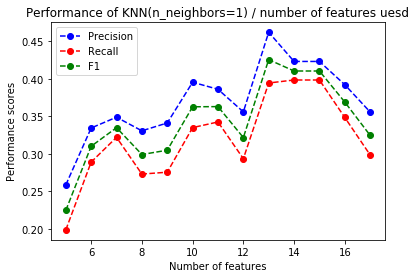

In [37]:
features_performance(KNeighborsClassifier(n_neighbors=1),'KNN(n_neighbors=1)')

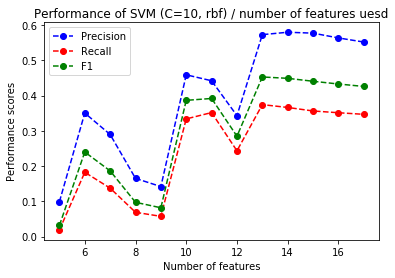

In [38]:
features_performance(SVC(kernel='rbf', C = 10),'SVM (C=10, rbf)')

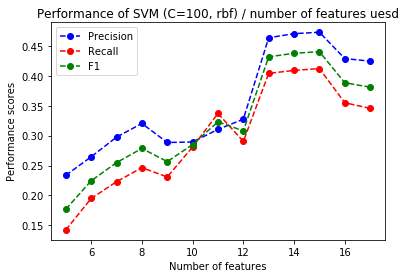

In [40]:
features_performance(SVC(kernel='rbf', C = 100),'SVM (C=100, rbf)')

From the figures above, SVM has the highest F1 scores and precision scores in large samples; KNN performs well on certain combination of features. 

In this project I'll use SVM(C=10, rbf, with 13 features) as the final estimator. It has the best performance and its running time is accetable.

## 6. Data leakage filters

For this data set there's another way that I can think of to boost the performance of my algorithm: data leakage filters. Recall in the very beginnig of this report we have a list of NaN's in each variable:

In [21]:
print(("Feature name").ljust(24) +  ("ROP in NaNs").rjust(9) + "  ROP in non-NaNs")
print("")

for key in features_list:
    ctr1 = 0
    ctr2 = 0
    ctr3 = 0
    for row in data:
        if (data[row][key] == "NaN"):
            ctr1 += 1
        if (data[row][key] == "NaN") and (data[row]['poi'] == True):
            ctr2 += 1
        if (data[row][key] != "NaN") and (data[row]['poi'] == True):
                ctr3 += 1
    print ((key).ljust(26)  + (str(ctr2)+"/"+str(ctr1)).rjust(9) +
                (str(ctr3)+"/"+str(146 - ctr1)).rjust(12))

Feature name            ROP in NaNs  ROP in non-NaNs

poi                             0/0      18/146
salary                         1/51       17/95
bonus                          2/64       16/82
long_term_incentive            6/80       12/66
deferred_income                7/97       11/49
deferral_payments            13/107        5/39
loan_advances                17/142         1/4
other                          0/53       18/93
expenses                       0/51       18/95
director_fees                18/129        0/17
total_payments                 0/21      18/125
exercised_stock_options        6/44      12/102
restricted_stock               1/36      17/110
restricted_stock_deferred    18/128        0/18
total_stock_value              0/20      18/126
email_address                  0/35      18/111
to_messages                    4/60       14/86
from_messages                  4/60       14/86
from_poi_to_this_person        4/60       14/86
from_this_person_to_poi        4/6

The table above allows us to set some filters. Say, if the director_fees column of a person is not NaN, they we can guess it's likely that he's not a POI because all POIs in this set are NaN's. We can do similar guesses for other columns like 'other', 'expenses', and so on. Each time this haapens to a person, the safety counter for that person +=1. Once the value of the safety counter for that person hits, say, 2 or 3, we can guess that person is very likely to be a non-POI. I'm not going to implement the algorithm here (because the cross validation set of this project is basically some reordering and repetitions of the all the data we have, this filter could make perfect guesses on a large portion of the cross validation set).

## 7 Vaildation and evaluation

### 7.1 Evaluation metric

The evaluation metric used in this report is precision, recall, and F1 score, but not accurancy rates. This is because our focus really is those POIs. precison is like the hit rate when we make guesses on POIs, and recall is like the ratio of how many bad guys are caught. Besides, in our data set, the propotion of POI is less than 20%, which makes accurancy rates inadequate (one can always guess on 0 to get high accuracy rates).

### 7.2 Cross validation methods

I found the figure posted in
https://discussions.udacity.com/t/gridsearchcv-and-testingtraining-data/36107/3
quite useful:

<img src="train_test_validate.png">

Usually we split our data set into training set, cross validation set, and test set. We use training set to build models, and then use cross validation set to tune parameters, and use test set to evaluate final performance. In this project, the data we have is quite few, so we have do things like the buttom case in the previous figure: we duplicate our data set, and then do random samplings. 

## 8. Reflection
### 8.1 What else can be done?
* Data Transformation<br/>
Other than log transformation, We can aslo try square root transformation, cube root transformation ..  as well (on data with long tails). Then we can test to see if other transformations can produce better results.

* Feature Scaling<br/>
Besides standard deviation scaling, we can also try min/max scaling on features. One thing to notice is that I don't think it's a good idea to do min/max scaling if the difference of max - min for different features differ by a lot.  

* Combination of estimators<br/>
If we have many good estimators, we can use them to create combined estimators. Say we have estimator A, B, C, a new estimator will predict on 1 if at least two of A, B, C predict on 1. Same for 0. Or, if estimator A is very good at catching 1's (although it's precision score is not high), we can create a combined estimator to predict on 0 once estimator A predicts on 0, and predict on 1 for certain outputs of A, B, C. 

### 8.2 few thoughts and questions

I'm curious about what other data scientists would do, like 
* On what situations they would create new features?<br/>
* How many paramters they will tune for a specific classifier?<br/>
* What paramters of classifier are worth to be tuned?<br/>
* How to stirke a balance between time efficiency and classifier performance<br/>
* Should we try different ways to do cross validations? Is there a guideline to decide how many pieces we should break our original data set and do cross validation? Is it a good idea to always use StratifiedShuffleSplit no matter how many data we have?<br/>
* How do we claim that the final estimator we produced is a good estimator?